In [1]:
import os

import numpy as np
import pandas as pd

import cv2

from scipy import stats
from scipy.signal import argrelmax, argrelmin
from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence

from google.colab import drive
from tqdm.notebook import tqdm

try:
    import pydicom
except ModuleNotFoundError:
    !pip install pydicom
    import pydicom

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device:', device)

drive.mount('/content/gdrive')
DATA_PATH = '/content/gdrive/My Drive/Pulmonary/data'

matplotlib.rcParams['xtick.color'] = 'white'
matplotlib.rcParams['ytick.color'] = 'white'
matplotlib.rcParams['axes.labelcolor'] = 'white'
matplotlib.rcParams['axes.labelcolor'] = 'white'

def cut_append(list_, maxlen, val=0):
    return list_[:maxlen] + [val] * (maxlen - len(list_))

     |████████████████████████████████| 35.5MB 85kB/s 
device: cuda
Mounted at /content/gdrive


In [3]:
train_listdir = os.listdir(os.path.join(DATA_PATH, 'train'))
train_listdir.remove('ID00011637202177653955184')  # cant read, sorry!
train_listdir.remove('ID00210637202257228694086')  # very bad pics, almost invisible, sorry!

In [5]:
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_train['Sex'] = df_train['Sex'].astype('category').cat.codes.astype(float)
df_train['SmokingStatus'] = df_train['SmokingStatus'].astype('category').cat.codes.astype(float) / 2
df_train['Age'] = df_train['Age'].astype('category').cat.codes.astype(float) / 100
df_train['Weeks'] = df_train['Weeks'].astype(int) + 12  # shift to non-negative range
df_train['FVC'] = df_train['FVC'].astype(int)
df_train['Percent'] = df_train['Percent'].astype(int)

In [6]:
def get_extended_df(patient, smooth_len=10, slice_cut=None):

    df = df_train[df_train['Patient'] == patient]
    df_short = df.iloc[0].copy()
    df_short['Weeks'] = df['Weeks'].values
    df_short['FVC'] = df['FVC'].values
    df_short['Percent'] = df['Percent'].values

    wks = df['Weeks'].values.reshape(-1, 1)
    fvc = df['FVC'].values.reshape(-1, 1)
    wks_ext = np.arange(146, dtype='float64').reshape(-1, 1)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(wks), np.squeeze(fvc))
    lin_fvc = slope * wks_ext + intercept

    if lin_fvc[-1] < df_train['FVC'].min():
        wks = np.append(wks, 145)
        fvc = np.append(fvc, df_train['FVC'].min())
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(wks), np.squeeze(fvc))
        lin_fvc = slope * wks_ext + intercept

    sigma = np.std(lin_fvc[[np.argwhere(wks_ext == w)[0][0] for w in wks]] - fvc)

    df_short['Slope'] = slope
    df_short['Intercept'] = intercept
    df_short['Sigma'] = sigma

    patient_path = os.path.join(DATA_PATH, 'train', patient)
    patient_dicom_file_numbers = sorted([int(f.split('.')[0]) for f in os.listdir(patient_path)])
    patient_listdir = [str(f) + '.dcm' for  f in patient_dicom_file_numbers]    

    if slice_cut is None:
        slice_cut = [9, 2, 3]  
    # select 9 slices evenly spaced and drop first 2 and last 3 slices due to bad picture at top and bottom of lung

    sel_n = np.linspace(0, len(patient_listdir)-1, num=slice_cut[0], dtype=np.int)
    sel_n = sel_n[slice_cut[1]:-slice_cut[2]]
    sel_listdir = [patient_listdir[i] for i in sel_n]

    df_short['Selected Slices'] = sel_listdir

    return df_short

In [7]:
columns=['Patient', 'Age', 'Sex', 'SmokingStatus', 'Weeks', 'FVC', 'Percent', 
         'Slope', 'Intercept', 'Sigma', 'Selected Slices']
df_train_short = pd.DataFrame(columns=columns)

for patient in train_listdir:
    df_train_short = df_train_short.append(get_extended_df(patient), sort=False)
df_train_short.reset_index()
df_train_short.head(1)

,Patient,Age,Sex,SmokingStatus,Weeks,FVC,Percent,Slope,Intercept,Sigma,Selected Slices
0,ID00007637202177411956430,0.29,1.0,0.5,"[8, 17, 19, 21, 23, 29, 41, 53, 69]","[2315, 2214, 2061, 2144, 2069, 2101, 2000, 206...","[58, 55, 51, 53, 52, 52, 50, 51, 51]",-3.167126,2212.421694,70.163262,"[8.dcm, 11.dcm, 15.dcm, 19.dcm]"


In [ ]:
# df_train_short.to_csv(os.path.join(DATA_PATH, 'df_train_short_.csv'))

In [85]:
def save_selected_slices(patient, subfolder, smooth_len=10, slice_cut=None):

    patient_path = os.path.join(DATA_PATH, subfolder, patient)
    patient_dicom_file_numbers = sorted([int(f.split('.')[0]) for f in os.listdir(patient_path)])
    patient_listdir = [str(f) + '.dcm' for  f in patient_dicom_file_numbers]

    if slice_cut is None:
        slice_cut = [9, 2, 3]

    sel_n = np.linspace(0, len(patient_listdir)-1, num=slice_cut[0], dtype=np.int)
    sel_n = sel_n[slice_cut[1]:-slice_cut[2]]
    sel_listdir = [patient_listdir[i] for i in sel_n]

    sel_array = np.zeros((len(sel_listdir), 512, 512), dtype='uint8')

    for i, f in enumerate(sel_listdir):

        dicom_slice = pydicom.dcmread(os.path.join(patient_path, f))        
        array = dicom_slice.pixel_array
        ar_hist, _ = np.histogram(array.ravel(), bins=256)
        ar_hist[np.argmax(ar_hist)] = 0
        ar_hist_smooth = np.convolve(ar_hist[1:], np.ones((smooth_len,)) / smooth_len, mode='valid')
        peaksmax = argrelmax(ar_hist_smooth, order=smooth_len, mode='wrap')[0]
        peaks = sorted(list(zip(peaksmax, ar_hist_smooth[peaksmax])), key=lambda x: x[1], reverse=True)
        [idxs, maxvals] = list(zip(*peaks))
        peaksmin = argrelmin(ar_hist_smooth, order=smooth_len, mode='wrap')[0]
        
        try:
            thresh = (idxs[0] + idxs[1]) // 2
        except IndexError:
            try:
                thresh = peaksmin[0] + smooth_len // 2
            except IndexError:
                thresh = peaks[0][0] // 2 + smooth_len // 2

        array_thresh = ((array  - array.min()) / (array.max() - array.min()) * 255).astype('uint8')
        if array_thresh.shape[0] != array_thresh.shape[1]:
            array_thresh = array_thresh[array_thresh.shape[0]//2 - 256:array_thresh.shape[0]//2 + 256, 
                                        array_thresh.shape[1]//2 - 256:array_thresh.shape[1]//2 + 256]
        if array_thresh.shape[0] > 512 or array_thresh.shape[1] > 512:
            array_thresh = np.array(Image.fromarray(array_thresh).resize((512, 512)))
        array_thresh = (array_thresh > thresh) * 255
        sel_array[i] = array_thresh
    return sel_array

In [9]:
df_train_short_arrays = []
for i, patient in enumerate(train_listdir):
    df_train_short_arrays.append(save_selected_slices(patient, 'train'))
df_train_short_arrays = np.stack(df_train_short_arrays, axis=0)
print(df_train_short_arrays.shape, df_train_short_arrays.dtype)

(174, 4, 512, 512) uint8


In [ ]:
# np.save(os.path.join(DATA_PATH, 'df_train_short_arrays.npy'), df_train_short_arrays)

In [10]:
cut_len = 700  # mean length of contours over dataset

def get_features(array):

    c_shapes = []
    c_areas = []
    for j in range(array.shape[0]):

        pic = array[j]
        conts, hier = cv2.findContours(pic, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        conts = sorted(conts, key=lambda x: max(x.shape), reverse=True)
        c_shape = [max(c.shape) for c in conts]
        c_area = [cv2.contourArea(c) for c in conts]

        c_shape = cut_append(c_shape, cut_len)
        c_area = cut_append(c_area, cut_len)

        c_shapes.append(c_shape)
        c_areas.append(c_area)   

    return c_shapes, c_areas

In [91]:
df_train_cont_shapes_arrays = []
df_train_cont_areas_arrays = []

for i in range(df_train_short_arrays.shape[0]):

    c_sh, c_ar = get_features(df_train_short_arrays[i])
    df_train_cont_shapes_arrays.append(c_sh)
    df_train_cont_areas_arrays.append(c_ar)

df_train_cont_shapes_arrays = np.array(df_train_cont_shapes_arrays)
df_train_cont_shapes_arrays = df_train_cont_shapes_arrays / df_train_cont_shapes_arrays.max()
df_train_cont_areas_arrays = np.array(df_train_cont_areas_arrays)
df_train_cont_areas_arrays = df_train_cont_areas_arrays / df_train_cont_areas_arrays.max()

print(df_train_cont_shapes_arrays.shape, df_train_cont_shapes_arrays.dtype, df_train_cont_areas_arrays.shape, df_train_cont_areas_arrays.dtype)

(174, 4, 700) float64 (174, 4, 700) float64


In [ ]:
# np.save(os.path.join(DATA_PATH, 'df_train_cont_shapes_arrays_.npy'), df_train_cont_shapes_arrays)
# np.save(os.path.join(DATA_PATH, 'df_train_cont_areas_arrays_.npy'), df_train_cont_areas_arrays)

## START FROM HERE IF PREPROCESSING DONE

In [26]:
# df_train_short = pd.read_csv(os.path.join(DATA_PATH, 'df_train_short_.csv'))
# df_train_short_arrays = np.load(os.path.join(DATA_PATH, 'df_train_short_arrays.npy'))
# df_train_cont_shapes_arrays = np.load(os.path.join(DATA_PATH, 'df_train_cont_shapes_arrays_.npy'))
# df_train_cont_areas_arrays = np.load(os.path.join(DATA_PATH, 'df_train_cont_areas_arrays_.npy'))

In [25]:
print(len(df_train_short), df_train_short_arrays.shape, df_train_cont_shapes_arrays.shape, df_train_cont_areas_arrays.shape)

174 (174, 4, 512, 512) (174, 4, 700) (174, 4, 700)


In [47]:
class FVCDataset(Dataset):

    def __init__(self, df, array1, array2, test=False):

        self.df = df.reset_index(drop=True)
        self.array1 = torch.FloatTensor(array1)
        self.array2 = torch.FloatTensor(array2)
        self.test = test

    def __len__(self):

        return len(self.df)

    def __getitem__(self, i):

        if isinstance(self.df.loc[i, 'Weeks'], str):  # after saving to file and reading back these columns are 'str'
            weeks = [int(w.strip()) for w in self.df.loc[i, 'Weeks'].strip().replace('[', '').replace(']', '').strip().split()]
            fvc = [int(w.strip()) for w in self.df.loc[i, 'FVC'].strip().replace('[', '').replace(']', '').strip().split()]
            perc = [int(w.strip()) for w in self.df.loc[i, 'Percent'].strip().replace('[', '').replace(']', '').strip().split()]
        else:
            weeks = self.df.loc[i, 'Weeks'].tolist()
            fvc = self.df.loc[i, 'FVC'].tolist()
            perc = self.df.loc[i, 'Percent'].tolist()

        id = self.df.loc[i, 'Patient']
        age = self.df.loc[i, 'Age']
        sex = self.df.loc[i, 'Sex']
        sm_stat = self.df.loc[i, 'SmokingStatus']

        if not self.test:
            slope = self.df.loc[i, 'Slope']
            intr = self.df.loc[i, 'Intercept']
            sigma = self.df.loc[i, 'Sigma']
        else:
            slope = 0.0
            intr = 0.0
            sigma = 0.0

        n = np.random.randint(self.array1.shape[1])

        return id, age, sex, sm_stat, slope, intr, sigma, weeks, fvc, perc, self.array1[i, n], self.array2[i, n]

In [49]:
def get_batch(ds, batch_size=None):

    if batch_size is None:  # validation
        batch = []
        for j in range(len(ds)):
            batch.append(ds[j])
        yield restruct_batch(batch)
    else:
        for i in range(0, len(ds), batch_size):
            batch = []
            for j in range(batch_size):
                try:
                    batch.append(ds[i+j])
                except:
                    break
            yield restruct_batch(batch)


def restruct_batch(batch):

    ids = [[b[0] for b in batch]]

    categorical_batch = torch.FloatTensor([b[1:4] for b in batch])    
    dicom_feature_batch1 = torch.stack([b[10] for b in batch])
    dicom_feature_batch2 = torch.stack([b[11] for b in batch])

    seq_lens = [len(b[7]) for b in batch]
    max_len = max(seq_lens)

    week_seq = torch.LongTensor([cut_append(b[7], max_len, val=200) for b in batch])
    fvc_seq = torch.LongTensor([cut_append(b[8], max_len) for b in batch])
    perc_seq = torch.LongTensor([cut_append(b[9], max_len) for b in batch])

    seq_lens = torch.LongTensor(seq_lens)

    target_data = torch.FloatTensor([b[4:7] for b in batch])
    # normalize targets - rescale to interval (0,1)
    target_data = target_data * torch.FloatTensor([1 / 100, 1 / 7000, 1 / 1000]).unsqueeze(0)

    return (ids, categorical_batch, dicom_feature_batch1, dicom_feature_batch2, 
            week_seq, fvc_seq, perc_seq, seq_lens, target_data)                                              

In [50]:
BATCH_SIZE = 17

indices = np.random.choice(list(range(len(df_train_short))), size=len(df_train_short))
train_indices, val_indices = indices[:170], indices[170:]

train_ds = FVCDataset(df_train_short.iloc[train_indices], df_train_cont_shapes_arrays[train_indices], df_train_cont_areas_arrays[train_indices])
val_ds = FVCDataset(df_train_short.iloc[val_indices], df_train_cont_shapes_arrays[val_indices], df_train_cont_areas_arrays[val_indices])

for batch in tqdm(get_batch(train_ds, batch_size=BATCH_SIZE)):
    pass

for batch in get_batch(val_ds):
    print(type(batch), len(batch), [list(t.shape) for t in batch[1:]], '\n', [t for t in batch[0]])


<class 'tuple'> 9 [[4, 3], [4, 700], [4, 700], [4, 9], [4, 9], [4, 9], [4], [4, 3]] 
 [['ID00035637202182204917484', 'ID00149637202232704462834', 'ID00351637202289476567312', 'ID00020637202178344345685']]


In [51]:
class AttentionWeight(nn.Module):

    def __init__(self, attention_dim):

        super().__init__()

        self.weights = nn.Sequential(
            nn.ReLU(),
            nn.Linear(attention_dim, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, att):
        
        return self.weights(att)


class Attention(nn.Module):

    def __init__(self, cat_feature_dim, dicom_feature_dim, rnn_dim, attention_dim):

        super().__init__()

        self.categorical_attn = nn.Linear(cat_feature_dim, attention_dim)
        self.dicom_feature_attn1 = nn.Linear(dicom_feature_dim, attention_dim)
        self.dicom_feature_attn2 = nn.Linear(dicom_feature_dim, attention_dim)

        self.rnn_attn = nn.Linear(rnn_dim, attention_dim)

        self.cat_weights = AttentionWeight(attention_dim)
        self.dicom1_weights = AttentionWeight(attention_dim)
        self.dicom2_weights = AttentionWeight(attention_dim)

    def forward(self, cat_features, dicom_features1, dicom_features2, rnn_hidden):

        rnn_attn = self.rnn_attn(rnn_hidden)

        cat_attn = self.categorical_attn(cat_features)
        dicom_attn1 = self.dicom_feature_attn1(dicom_features1)
        dicom_attn2 = self.dicom_feature_attn2(dicom_features2)

        cat_alphas = self.cat_weights(cat_attn + rnn_attn)
        dicom1_alphas = self.cat_weights(dicom_attn1 + rnn_attn)
        dicom2_alphas = self.cat_weights(dicom_attn2 + rnn_attn)

        weighted_cat_features = (cat_features * cat_alphas)
        weighted_dicom_features1 = (dicom_features1 * dicom1_alphas)
        weighted_dicom_features2 = (dicom_features2 * dicom2_alphas)

        return weighted_cat_features, weighted_dicom_features1, weighted_dicom_features2

In [52]:
HIDDEN_DIM = 64
ATTN_DIM = 32 

att_net = Attention(3, 700, HIDDEN_DIM, ATTN_DIM).to(device)
att_net

Attention(
  (categorical_attn): Linear(in_features=3, out_features=32, bias=True)
  (dicom_feature_attn1): Linear(in_features=700, out_features=32, bias=True)
  (dicom_feature_attn2): Linear(in_features=700, out_features=32, bias=True)
  (rnn_attn): Linear(in_features=64, out_features=32, bias=True)
  (cat_weights): AttentionWeight(
    (weights): Sequential(
      (0): ReLU()
      (1): Linear(in_features=32, out_features=1, bias=True)
      (2): Softmax(dim=1)
    )
  )
  (dicom1_weights): AttentionWeight(
    (weights): Sequential(
      (0): ReLU()
      (1): Linear(in_features=32, out_features=1, bias=True)
      (2): Softmax(dim=1)
    )
  )
  (dicom2_weights): AttentionWeight(
    (weights): Sequential(
      (0): ReLU()
      (1): Linear(in_features=32, out_features=1, bias=True)
      (2): Softmax(dim=1)
    )
  )
)

In [54]:
for batch in tqdm(get_batch(train_ds, batch_size=BATCH_SIZE)):

    print([tens.shape for tens in batch[1:]])
    ids, cat_batch, dicom1_batch, dicom2_batch, week_seq, fvc_seq, perc_seq, seqlens, targets = batch
    cat_batch = cat_batch.to(device)
    dicom1_batch = dicom1_batch.to(device)
    dicom2_batch = dicom2_batch.to(device)
    # week_seq = week_seq.to('cuda')
    # fvc_seq = week_seq.to('cuda')
    # perc_seq = week_seq.to('cuda')
    # seqlens = seqlens.to('cuda')
    # targets = targets.to('cuda')
    
    hidden = torch.rand(BATCH_SIZE, HIDDEN_DIM).to(device)

    cat, dicom1, dicom2 = att_net(cat_batch, dicom1_batch, dicom2_batch, hidden)
    print(cat.shape, dicom1.shape, dicom2.shape)

    break

[torch.Size([17, 3]), torch.Size([17, 700]), torch.Size([17, 700]), torch.Size([17, 9]), torch.Size([17, 9]), torch.Size([17, 9]), torch.Size([17]), torch.Size([17, 3])]
torch.Size([17, 3]) torch.Size([17, 700]) torch.Size([17, 700])


In [55]:
class HiddenGate(nn.Module):

    def __init__(self, hidden_dim, feature_dim):

        super().__init__()

        self.gates = nn.Sequential(
            nn.Linear(hidden_dim, feature_dim),
            nn.Sigmoid()
        )

    def forward(self, hid):

        return self.gates(hid)

class OSICnet(nn.Module):

    def __init__(self, cat_feature_dim, dicom_feature_dim, rnn_dim, embedding_dim, attention_dim, p=0.5, device=device):

        super().__init__()

        self.rnn_dim = rnn_dim
        self.device = device

        self.att_net = Attention(3, 700, rnn_dim, attention_dim)

        self.weeks_embedding = nn.Embedding(201, embedding_dim)
        self.fvcs_embedding = nn.Embedding(7001, embedding_dim)
        self.percs_embedding = nn.Embedding(201, embedding_dim)

        self.gated_h_for_cat = HiddenGate(rnn_dim, cat_feature_dim)
        self.gated_h_for_dicom1 = HiddenGate(rnn_dim, dicom_feature_dim)
        self.gated_h_for_dicom2 = HiddenGate(rnn_dim, dicom_feature_dim)

        self.rnn = nn.LSTMCell(embedding_dim * 3 + cat_feature_dim + dicom_feature_dim * 2, rnn_dim, bias=True)

        self.dropout = nn.Dropout(p=p)
        self.predict = nn.Linear(rnn_dim, 3)
        self.init_weights()

    def init_weights(self):

        self.weeks_embedding.weight.data.uniform_(-0.1, 0.1)
        self.fvcs_embedding.weight.data.uniform_(-0.1, 0.1)
        self.percs_embedding.weight.data.uniform_(-0.1, 0.1)
        self.predict.bias.data.fill_(0)
        self.predict.weight.data.uniform_(-0.1, 0.1)

    def init_hidden(self, size):

        return (torch.zeros(size, self.rnn_dim).to(self.device),
                torch.zeros(size, self.rnn_dim).to(self.device))       

    def forward(self, cat_features, dicom1_features, dicom2_features, weeks, fvcs, percs, seq_lens):

        seq_lens, sort_ind = seq_lens.sort(dim=0, descending=True)
        cat_features = cat_features[sort_ind]
        dicom1_features = dicom1_features[sort_ind]
        dicom2_features = dicom2_features[sort_ind]
        weeks = weeks[sort_ind]
        fvcs = fvcs[sort_ind]
        percs = percs[sort_ind]

        weeks_emb = self.weeks_embedding(weeks)
        fvcs_emb = self.fvcs_embedding(fvcs)
        percs_emb = self.percs_embedding(percs)

        h, c = self.init_hidden(seq_lens.size(0))

        lengths = seq_lens.tolist()
        predictions = torch.zeros(seq_lens.size(0), max(lengths), 3).to(self.device)

        for t in range(max(lengths)):
            batch_size_t = sum([l > t for l in lengths])

            attentions = self.att_net(cat_features[:batch_size_t], 
                                      dicom1_features[:batch_size_t], 
                                      dicom2_features[:batch_size_t], 
                                      h[:batch_size_t])
            weighted_cat, weighted_dicom1, weighted_dicom2 = attentions

            cat_gate = self.gated_h_for_cat(h[:batch_size_t])
            dicom1_gate = self.gated_h_for_dicom1(h[:batch_size_t])
            dicom2_gate = self.gated_h_for_dicom2(h[:batch_size_t])

            weighted_cat = cat_gate * weighted_cat
            weighted_dicom1 = dicom1_gate * weighted_dicom1
            weighted_dicom2 = dicom2_gate * weighted_dicom2

            h, c = self.rnn(
                torch.cat([weeks_emb[:batch_size_t, t, :], 
                           fvcs_emb[:batch_size_t, t, :], 
                           percs_emb[:batch_size_t, t, :], 
                           weighted_cat, 
                           weighted_dicom1, 
                           weighted_dicom2], dim=1),
                (h[:batch_size_t], c[:batch_size_t])
            )

            preds = self.predict(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds

        return predictions, sort_ind, lengths
try:
    del fvc_net
except NameError:
    pass

In [56]:
EMBED_DIM = 32

fvc_net = OSICnet(3, 700, HIDDEN_DIM, EMBED_DIM, ATTN_DIM, device=device)
fvc_net = fvc_net.to(device)
crit = nn.MSELoss()
fvc_net

OSICnet(
  (att_net): Attention(
    (categorical_attn): Linear(in_features=3, out_features=32, bias=True)
    (dicom_feature_attn1): Linear(in_features=700, out_features=32, bias=True)
    (dicom_feature_attn2): Linear(in_features=700, out_features=32, bias=True)
    (rnn_attn): Linear(in_features=64, out_features=32, bias=True)
    (cat_weights): AttentionWeight(
      (weights): Sequential(
        (0): ReLU()
        (1): Linear(in_features=32, out_features=1, bias=True)
        (2): Softmax(dim=1)
      )
    )
    (dicom1_weights): AttentionWeight(
      (weights): Sequential(
        (0): ReLU()
        (1): Linear(in_features=32, out_features=1, bias=True)
        (2): Softmax(dim=1)
      )
    )
    (dicom2_weights): AttentionWeight(
      (weights): Sequential(
        (0): ReLU()
        (1): Linear(in_features=32, out_features=1, bias=True)
        (2): Softmax(dim=1)
      )
    )
  )
  (weeks_embedding): Embedding(201, 32)
  (fvcs_embedding): Embedding(7001, 32)
  (percs

In [58]:
try:
    del fvc_net
except NameError:
    pass

EMBED_DIM = 32

fvc_net = OSICnet(3, 700, HIDDEN_DIM, EMBED_DIM, ATTN_DIM, device=device)
fvc_net = fvc_net.to(device)

crit = nn.MSELoss()

for batch in tqdm(get_batch(train_ds, batch_size=BATCH_SIZE)):

    print([tens.shape for tens in batch[1:]])
    ids, cat_batch, dicom1_batch, dicom2_batch, week_seq, fvc_seq, perc_seq, seqlens, targets = batch
    cat_batch = cat_batch.to(device)
    dicom1_batch = dicom1_batch.to(device)
    dicom2_batch = dicom2_batch.to(device)
    week_seq = week_seq.to(device)
    fvc_seq = week_seq.to(device)
    perc_seq = week_seq.to(device)
    seqlens = seqlens.to(device)

    preds, idxs, lengths = fvc_net(cat_batch, dicom1_batch, dicom2_batch, week_seq, fvc_seq, perc_seq, seqlens)
    preds_mean = preds.mean(dim=1)
    print(preds.shape, preds_mean.shape)

    targets = targets[idxs]
    targets = targets.unsqueeze(1).repeat(1, seqlens.max(), 1).to(device)

    preds_packed = pack_padded_sequence(preds, lengths, batch_first=True)
    targets_packed = pack_padded_sequence(targets, lengths, batch_first=True)

    loss = crit(preds_packed.data, targets_packed.data)
    print(preds_packed.data.shape, idxs.shape, targets_packed.data.shape)

    # print('Targets:\n', targets[:, -1, :])
    # print('Predictions:\n', preds[:, -1, :])

    break

[torch.Size([17, 3]), torch.Size([17, 700]), torch.Size([17, 700]), torch.Size([17, 9]), torch.Size([17, 9]), torch.Size([17, 9]), torch.Size([17]), torch.Size([17, 3])]
torch.Size([17, 9, 3]) torch.Size([17, 3])
torch.Size([144, 3]) torch.Size([17]) torch.Size([144, 3])


In [71]:
def train(net, optimizer, criterion, num_epochs=25, 
          loss_array=None, device=device, savefile='model.pt'):
    
    if loss_array is None:
        loss_array = []
        best_loss = np.inf
    else:
        best_loss = min(loss_array[:, 1])
        loss_array = loss_array.tolist()

    preds_best = None
    targets_best = None  

    for epoch in range(num_epochs):

        train_loss = 0
        net.train(True)
        
        for batch in get_batch(train_ds, batch_size=BATCH_SIZE):

            cat_batch = batch[1].to(device)
            dicom1_batch = batch[2].to(device)
            dicom2_batch = batch[3].to(device)
            week_seq = batch[4].to(device)
            fvc_seq = batch[5].to(device)
            perc_seq = batch[6].to(device)
            seqlens = batch[7].to(device)
            targets = batch[8].to(device)

            preds, idxs, lengths = net(cat_batch, dicom1_batch, dicom2_batch, week_seq, fvc_seq, perc_seq, seqlens)

            targets = targets[idxs]
            targets = targets.unsqueeze(1).repeat(1, seqlens.max(), 1).to(device)

            preds_packed = pack_padded_sequence(preds, lengths, batch_first=True)
            targets_packed = pack_padded_sequence(targets, lengths, batch_first=True)

            loss = criterion(preds_packed.data, targets_packed.data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().data.numpy()

        train_loss /= len(train_ds)

        valid_loss = 0
        net.train(False)
        
        for batch in get_batch(val_ds):

            cat_batch = batch[1].to(device)
            dicom1_batch = batch[2].to(device)
            dicom2_batch = batch[3].to(device)
            week_seq = batch[4].to(device)
            fvc_seq = batch[5].to(device)
            perc_seq = batch[6].to(device)
            seqlens = batch[7].to(device)
            targets = batch[8].to(device)

            preds, idxs, lengths = net(cat_batch, dicom1_batch, dicom2_batch, week_seq, fvc_seq, perc_seq, seqlens)

            targets = targets[idxs]
            targets = targets.unsqueeze(1).repeat(1, seqlens.max(), 1).to(device)

            preds_packed = pack_padded_sequence(preds, lengths, batch_first=True)
            targets_packed = pack_padded_sequence(targets, lengths, batch_first=True)

            loss = criterion(preds_packed.data, targets_packed.data)

            valid_loss += loss.cpu().data.numpy()

        valid_loss /= len(val_ds)

        loss_array.append([train_loss, valid_loss])

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save({
                        'EMBED_DIM': EMBED_DIM,
                        'ATTN_DIM': ATTN_DIM,
                        'HIDDEN_DIM': HIDDEN_DIM,
                        'BATCH_SIZE': BATCH_SIZE,
                        'loss_array': np.array(loss_array),                        
                        'net_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),                        
                        }, savefile)
            preds_best = preds.mean(dim=1)
            targets_best = targets.mean(dim=1)

        if (epoch + 1) % 20 == 0.0:
            print(f'EPOCH: {epoch+1} - Train loss: {train_loss:.6f}, Validation loss: {valid_loss:.6f}') 
        
    checkpoint = torch.load(savefile)     
    net.load_state_dict(checkpoint['net_state_dict'])

    print('Best prediction:\n', preds_best, '\n', targets_best)

    return net, np.array(loss_array)

In [72]:
LOAD = False

In [73]:
try:
    del fvc_net
except NameError:
    pass

if not LOAD:
    EMBED_DIM = 32
    HIDDEN_DIM = 256
    ATTN_DIM = 128
    LEARN_RATE = 0.00003
    SAVEFILE = os.path.join(DATA_PATH, 'model_new.pt')

    fvc_net = OSICnet(3, 700, HIDDEN_DIM, EMBED_DIM, ATTN_DIM, device=device)
    fvc_net = fvc_net.to(device)

    crit = nn.MSELoss()
    opt = torch.optim.Adam(params=fvc_net.parameters(), lr=LEARN_RATE)

    fvc_net, losses = train(fvc_net, opt, crit, num_epochs=300, savefile=SAVEFILE)


EPOCH: 20 - Train loss: 0.001488, Validation loss: 0.003425
EPOCH: 40 - Train loss: 0.001226, Validation loss: 0.002629
EPOCH: 60 - Train loss: 0.001032, Validation loss: 0.002109
EPOCH: 80 - Train loss: 0.000864, Validation loss: 0.001761
EPOCH: 100 - Train loss: 0.000701, Validation loss: 0.001357
EPOCH: 120 - Train loss: 0.000537, Validation loss: 0.001223
EPOCH: 140 - Train loss: 0.000404, Validation loss: 0.001061
EPOCH: 160 - Train loss: 0.000323, Validation loss: 0.000924
EPOCH: 180 - Train loss: 0.000268, Validation loss: 0.000853
EPOCH: 200 - Train loss: 0.000235, Validation loss: 0.000894
EPOCH: 220 - Train loss: 0.000207, Validation loss: 0.000754
EPOCH: 240 - Train loss: 0.000181, Validation loss: 0.000682
EPOCH: 260 - Train loss: 0.000160, Validation loss: 0.000698
EPOCH: 280 - Train loss: 0.000149, Validation loss: 0.000638
EPOCH: 300 - Train loss: 0.000133, Validation loss: 0.000616
Best prediction:
 tensor([[-0.0756,  0.5123,  0.0707],
        [-0.0332,  0.4040,  0.1102

(300, 2)


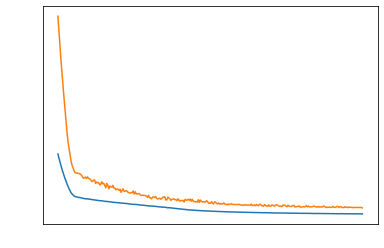

In [74]:
losses = np.array(losses)
print(losses.shape)
plt.plot(losses[:, 0])
plt.plot(losses[:, 1])
plt.show()

In [75]:
LOAD = True  # False - means FIRST RUN OF LEARNING

In [76]:
if LOAD:
    LOADFILE = os.path.join(DATA_PATH, 'model_new.pt')
    checkpoint = torch.load(LOADFILE)

    EMBED_DIM = checkpoint['EMBED_DIM']
    ATTN_DIM = checkpoint['ATTN_DIM']
    HIDDEN_DIM = checkpoint['HIDDEN_DIM']
    BATCH_SIZE = checkpoint['BATCH_SIZE']
    loss_array = checkpoint['loss_array']
    print(EMBED_DIM, ATTN_DIM, HIDDEN_DIM, BATCH_SIZE)

    SAVEFILE = os.path.join(DATA_PATH, 'model_new2.pt')

    fvc_net = OSICnet(3, 700, HIDDEN_DIM, EMBED_DIM, ATTN_DIM, device=device)
    fvc_net.load_state_dict(checkpoint['net_state_dict'])
    fvc_net.train(False)
    fvc_net = fvc_net.to(device)

32 128 256 17


In [77]:
EVAL = False  # CONTINUE LEARNING

In [79]:
if not EVAL:
    LEARN_RATE = 0.00001
    
    crit = nn.MSELoss()
    opt = torch.optim.Adam(params=fvc_net.parameters(), lr=LEARN_RATE)
    opt.load_state_dict(checkpoint['optimizer_state_dict'])

    fvc_net, losses = train(fvc_net, opt, crit, num_epochs=300, loss_array=loss_array, savefile=SAVEFILE)

EPOCH: 20 - Train loss: 0.000062, Validation loss: 0.000608
EPOCH: 40 - Train loss: 0.000062, Validation loss: 0.000607
EPOCH: 60 - Train loss: 0.000059, Validation loss: 0.000614
EPOCH: 80 - Train loss: 0.000057, Validation loss: 0.000598
EPOCH: 100 - Train loss: 0.000057, Validation loss: 0.000596
EPOCH: 120 - Train loss: 0.000053, Validation loss: 0.000603
EPOCH: 140 - Train loss: 0.000052, Validation loss: 0.000622
EPOCH: 160 - Train loss: 0.000053, Validation loss: 0.000604
EPOCH: 180 - Train loss: 0.000048, Validation loss: 0.000624
EPOCH: 200 - Train loss: 0.000048, Validation loss: 0.000640
EPOCH: 220 - Train loss: 0.000049, Validation loss: 0.000638
EPOCH: 240 - Train loss: 0.000046, Validation loss: 0.000620
EPOCH: 260 - Train loss: 0.000047, Validation loss: 0.000625
EPOCH: 280 - Train loss: 0.000047, Validation loss: 0.000616
EPOCH: 300 - Train loss: 0.000043, Validation loss: 0.000625
Best prediction:
 tensor([[-0.0862,  0.5318,  0.0731],
        [-0.0340,  0.3906,  0.0861

## EVALUATE TEST DATA AND MAKE SUBMISSION CSV

In [80]:
test_listdir = os.listdir(os.path.join(DATA_PATH, 'test'))
test_listdir

['ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466']

In [81]:
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_test['Sex'] = df_test['Sex'].astype('category').cat.codes.astype(float)
df_test['SmokingStatus'] = df_test['SmokingStatus'].astype('category').cat.codes.astype(float) / 2
df_test['Age'] = df_test['Age'].astype('category').cat.codes.astype(float) / 100
df_test['Weeks'] = df_test['Weeks'].astype(int) + 12  # shift to non-negative range
df_test['FVC'] = df_test['FVC'].astype(int)
df_test['Percent'] = df_test['Percent'].astype(int)
print(df_test)

                     Patient  Weeks   FVC  Percent   Age  Sex  SmokingStatus
0  ID00419637202311204720264     18  3020       70  0.02  0.0            0.0
1  ID00421637202311550012437     27  2739       82  0.00  0.0            0.0
2  ID00422637202311677017371     18  1930       76  0.02  0.0            0.0
3  ID00423637202312137826377     29  3294       79  0.01  0.0            0.0
4  ID00426637202313170790466     12  2925       71  0.02  0.0            0.5


In [82]:
def get_test_df(patient, smooth_len=10, slice_cut=None):

    df = df_test[df_test['Patient'] == patient]
    df_short = df.iloc[0].copy()
    # repeat one time, next week, to emulate sequence, like in train data
    df_short['Weeks'] = np.repeat(df['Weeks'].values, 2, axis=0)
    df_short['FVC'] = np.repeat(df['FVC'].values, 2, axis=0)
    df_short['Percent'] = np.repeat(df['Percent'].values, 2, axis=0)

    patient_path = os.path.join(DATA_PATH, 'test', patient)
    patient_dicom_file_numbers = sorted([int(f.split('.')[0]) for f in os.listdir(patient_path)])
    patient_listdir = [str(f) + '.dcm' for  f in patient_dicom_file_numbers]    

    if slice_cut is None:
        slice_cut = [9, 2, 3]  
    # select 9 slices evenly spaced and drop first 2 and last 3 slices due to bad picture at top and bottom of lung

    sel_n = np.linspace(0, len(patient_listdir)-1, num=slice_cut[0], dtype=np.int)
    sel_n = sel_n[slice_cut[1]:-slice_cut[2]]
    sel_listdir = [patient_listdir[i] for i in sel_n]

    df_short['Selected Slices'] = sel_listdir

    return df_short

In [83]:
columns=['Patient', 'Age', 'Sex', 'SmokingStatus', 'Weeks', 'FVC', 'Percent', 'Selected Slices']
df_test_short = pd.DataFrame(columns=columns)

for patient in test_listdir:
    df_test_short = df_test_short.append(get_test_df(patient), sort=False)
df_test_short.reset_index()
df_test_short.head(len(test_listdir))

,Patient,Age,Sex,SmokingStatus,Weeks,FVC,Percent,Selected Slices
0,ID00419637202311204720264,0.02,0.0,0.0,"[18, 18]","[3020, 3020]","[70, 70]","[7.dcm, 11.dcm, 14.dcm, 17.dcm]"
1,ID00421637202311550012437,0.00,0.0,0.0,"[27, 27]","[2739, 2739]","[82, 82]","[16.dcm, 23.dcm, 31.dcm, 39.dcm]"
2,ID00422637202311677017371,0.02,0.0,0.0,"[18, 18]","[1930, 1930]","[76, 76]","[119.dcm, 178.dcm, 237.dcm, 296.dcm]"
3,ID00423637202312137826377,0.01,0.0,0.0,"[29, 29]","[3294, 3294]","[79, 79]","[73.dcm, 109.dcm, 145.dcm, 181.dcm]"
4,ID00426637202313170790466,0.02,0.0,0.5,"[12, 12]","[2925, 2925]","[71, 71]","[102.dcm, 153.dcm, 204.dcm, 255.dcm]"


In [86]:
df_test_short_arrays = []
for i, patient in enumerate(test_listdir):
    df_test_short_arrays.append(save_selected_slices(patient, 'test'))
df_test_short_arrays = np.stack(df_test_short_arrays, axis=0)
print(df_test_short_arrays.shape, df_test_short_arrays.dtype)

(5, 4, 512, 512) uint8


In [90]:
df_test_cont_shapes_arrays = []
df_test_cont_areas_arrays = []

for i in range(df_test_short_arrays.shape[0]):

    c_sh, c_ar = get_features(df_test_short_arrays[i])
    df_test_cont_shapes_arrays.append(c_sh)
    df_test_cont_areas_arrays.append(c_ar)

df_test_cont_shapes_arrays = np.array(df_test_cont_shapes_arrays)
df_test_cont_shapes_arrays = df_test_cont_shapes_arrays / df_test_cont_shapes_arrays.max()
df_test_cont_areas_arrays = np.array(df_test_cont_areas_arrays)
df_test_cont_areas_arrays = df_test_cont_areas_arrays / df_test_cont_areas_arrays.max()

print(df_test_cont_shapes_arrays.shape, df_test_cont_shapes_arrays.dtype, df_test_cont_areas_arrays.shape, df_test_cont_areas_arrays.dtype)

(5, 4, 700) float64 (5, 4, 700) float64


In [92]:
test_ds = FVCDataset(df_test_short, df_test_cont_shapes_arrays, df_test_cont_areas_arrays, test=True)

for batch in get_batch(test_ds, batch_size=1):
    print(type(batch), len(batch), [list(t.shape) for t in batch[1:]], '\n', [t for t in batch[0]])
    break

<class 'tuple'> 9 [[1, 3], [1, 700], [1, 700], [1, 2], [1, 2], [1, 2], [1], [1, 3]] 
 [['ID00419637202311204720264']]


In [93]:
def predict(batch, net, device=device):

    cat_batch = batch[1].to(device)
    dicom1_batch = batch[2].to(device)
    dicom2_batch = batch[3].to(device)
    week_seq = batch[4].to(device)
    fvc_seq = batch[5].to(device)
    perc_seq = batch[6].to(device)
    seqlens = batch[7].to(device)

    preds, _, _ = net(cat_batch, dicom1_batch, dicom2_batch, week_seq, fvc_seq, perc_seq, seqlens)

    preds = preds.mean(dim=1).detach().cpu()
    # denormalize - scale back
    preds_denorm = preds * torch.FloatTensor([100, 7000, 1000]).unsqueeze(0)
    preds_denorm = np.squeeze(preds_denorm.numpy(), axis=0).tolist()
    
    return preds_denorm

In [94]:
predictions = [] 
for batch in get_batch(test_ds, batch_size=1):
    pred = predict(batch, fvc_net)
    predictions.append([batch[0][0][0], pred])
predictions

[['ID00419637202311204720264',
  [0.07155421376228333, 2832.33154296875, 20.137250900268555]],
 ['ID00421637202311550012437',
  [-1.8841221332550049, 2255.556884765625, 102.31232452392578]],
 ['ID00422637202311677017371',
  [-0.2410067319869995, 2156.552734375, 116.45934295654297]],
 ['ID00423637202312137826377',
  [-7.863607406616211, 3134.708740234375, 178.8648681640625]],
 ['ID00426637202313170790466',
  [-5.114653587341309, 3339.519287109375, 64.64082336425781]]]

In [95]:
sample_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
sample_df.head(1)

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100


In [98]:
submission_df = []

for w in range(146):
    for i in range(len(predictions)):
        id_ = predictions[i][0]
        slope = predictions[i][1][0]
        itercept = predictions[i][1][1]
        sigma = predictions[i][1][2]
        fvc = slope * w + itercept# + np.random.randn() * sigma

        submission_df.append((id_ + '_' + str(w - 12), round(fvc), round(sigma)))

submission_df = pd.DataFrame(submission_df, columns=sample_df.columns)  

In [99]:
print(submission_df)
submission_df.to_csv(os.path.join(DATA_PATH, 'yenkov_submission2.csv'), index=False)

                      Patient_Week   FVC  Confidence
0    ID00419637202311204720264_-12  2832          20
1    ID00421637202311550012437_-12  2256         102
2    ID00422637202311677017371_-12  2157         116
3    ID00423637202312137826377_-12  3135         179
4    ID00426637202313170790466_-12  3340          65
..                             ...   ...         ...
725  ID00419637202311204720264_133  2843          20
726  ID00421637202311550012437_133  1982         102
727  ID00422637202311677017371_133  2122         116
728  ID00423637202312137826377_133  1994         179
729  ID00426637202313170790466_133  2598          65

[730 rows x 3 columns]
